## Quantitative Risk Management Assignement
Giuliano Cunti <br>
Lukas Schreiner
<br>
Due: 2.Dec.2018

In [1]:
#Import Libraries
import numpy as np
import pandas as pd

from copulas.bivariate.base import Bivariate
from copulas.multivariate.gaussian import GaussianMultivariate
import scipy.stats as st

import matplotlib.pyplot as plt

#Set random number seed in order to generate coherent results
np.random.seed(1)

In [2]:
#Disable Warnings 
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
#Import Data MXEUC Index
data1 = pd.read_excel('qrm18HSG_assignmentdata.xlsx', usecols = "A,B" ,
                      names = [ 'Date', 'MXEUC Index']).set_index('Date')
data1 = data1.iloc[1:]
#Import Data SPX Index
data2 = pd.read_excel('qrm18HSG_assignmentdata.xlsx', usecols = "C,D" ,
                      names = [ 'Date', 'SPX Index']).set_index('Date')
data2 = data2.iloc[1:]

#Merge Data
data = pd.concat([data1, data2], axis = 1, join_axes = [data1.index])

#Convert to numerical values interpolate missing values
data['SPX Index'] = pd.to_numeric(data['SPX Index'])
data['MXEUC Index'] = pd.to_numeric(data['MXEUC Index'])
data['SPX Index'] = data['SPX Index'].interpolate()

#Calculate Returns of the Indices
data['MXEUC Returns'] = data['MXEUC Index']/data['MXEUC Index'].shift(1) - 1
data['SPX Returns'] = data['SPX Index']/data['SPX Index'].shift(1) - 1

data['LT Returns'] = (0.3 * data['MXEUC Returns'] + 0.7 * data['SPX Returns'])

#Only take the latest 500 Oberservations (Questions i,ii, iii)
data_500 = data.iloc[1:501]

data_500.head()

,MXEUC Index,SPX Index,MXEUC Returns,SPX Returns,LT Returns
Date,,,,,
2005-01-03,89.6602,1202.0891,0.005159,-0.008109,-0.004128
2005-01-04,90.0505,1188.1801,0.004353,-0.011571,-0.006794
2005-01-05,89.4664,1183.9815,-0.006486,-0.003534,-0.004419
2005-01-06,89.9265,1188.3980,0.005143,0.003730,0.004154
2005-01-07,90.6058,1186.7126,0.007554,-0.001418,0.001273


### Question i)

<b>Model 1</b>

In [4]:
#Calculate the emprical CDF
empricial_cdf = np.array([data_500.sort_values('MXEUC Returns')\
                         ['MXEUC Returns'].values, 
                          data_500.sort_values('SPX Returns')\
                         ['SPX Returns'].values,
                          data_500.sort_values('LT Returns')\
                         ['LT Returns'].values])

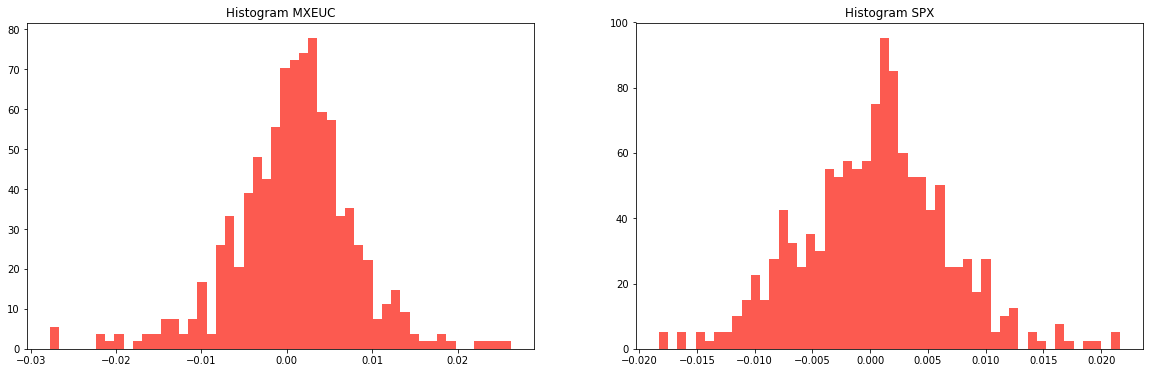

In [5]:
#Plot CDF and histogramm of the MXEUC
figure_indices = plt.figure(figsize = (20,6))

chart_1  = figure_indices.add_subplot(121)
chart_1.hist(empricial_cdf[0], 50 ,density = True, facecolor = 'xkcd:coral')
chart_1.set_title('Histogram MXEUC')

chart_2  = figure_indices.add_subplot(122)
chart_2.hist(empricial_cdf[1], 50 ,density = True, facecolor = 'xkcd:coral')
chart_2.set_title('Histogram SPX')

plt.show()

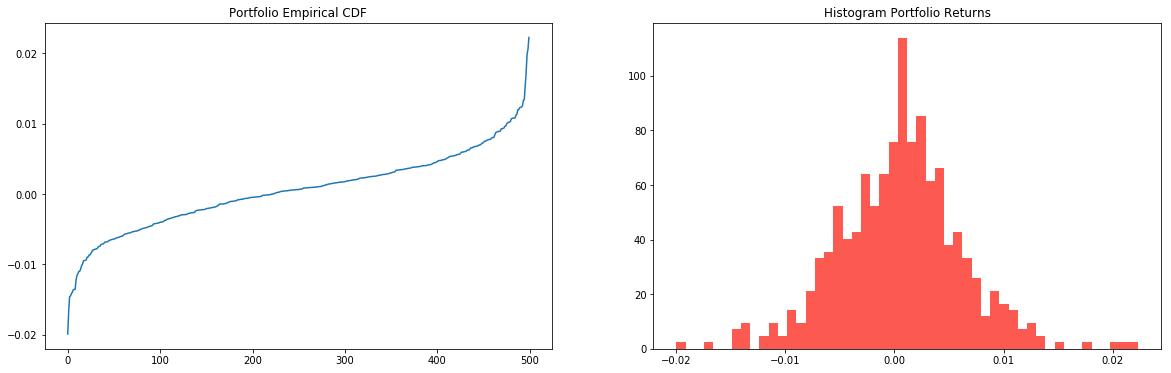

In [6]:
#Plot CDF and histogramm of the SPX
figure_portfolio = plt.figure(figsize = (20,6))

chart_1  = figure_portfolio.add_subplot(121)
chart_1.plot(empricial_cdf[2])
chart_1.set_title('Portfolio Empirical CDF')

chart_2  = figure_portfolio.add_subplot(122)
chart_2.hist(empricial_cdf[2], 50 ,density = True, facecolor = 'xkcd:coral')
chart_2.set_title('Histogram Portfolio Returns')

plt.show()

<b>Model 2</b>

In [7]:
#Calculate Sample Means and Covariance Matrix
def sample_moments_indices(data):

    means = [np.mean(data['MXEUC Returns']), 
             np.mean(data['SPX Returns'])]
    
    stds  = [np.std(data['MXEUC Returns']), 
             np.std(data['SPX Returns'])]
    
    cov_mat = np.cov(data['MXEUC Returns'], 
                     data['SPX Returns'], ddof = 0)
    
    return means, cov_mat, stds

In [8]:
#Calculate the sample means of the latest 500 obervations
means, cov_mat, stds =  sample_moments_indices(data_500)
print(means)
print(cov_mat)
print(stds)

[0.0007688865556201618, 0.00037513875090646164]
[[5.06108727e-05 1.92605961e-05]
 [1.92605961e-05 3.91579477e-05]]
[0.007114131899084827, 0.006257631156282389]


<b>Model 3</b> 

In [9]:
#Normalize the data
data_500['MXEUC Returns Normalized'] = (data_500['MXEUC Returns'] - means[0])/\
                                       (np.sqrt(cov_mat[0][0]))
data_500['SPX Returns Normalized']   = (data_500['SPX Returns'] - means[1])/\
                                       (np.sqrt(cov_mat[1][1]))

#Apply the normalized data on a CDF to get probablities
data_500['MXEUC RN CDF'] = st.norm.cdf(data_500['MXEUC Returns Normalized'].values)
data_500['SPX RN CDF']   = st.norm.cdf(data_500['SPX Returns Normalized'].values)

In [10]:
#Create an array that contains only the return data
copula_data = np.array([data_500['MXEUC Returns'], data_500['SPX Returns']]).T

In [11]:
#Fit a bivariate gumbel copula
#The copulas library from Data to AI Lab at MIT is used
#https://pypi.org/project/copulas/

gumbel = Bivariate(copula_type = 'Gumbel')
gumbel.fit(copula_data)
gumbel.compute_theta()

1.3831731143911365

<b>Model 4</b>

In [12]:
def model_4(data, size):
    
    #Calculate covariance matrix
    cov_mat  = np.corrcoef(data['MXEUC Returns'], data['SPX Returns'])
    
    #Calculate sample momemts
    means, _, stds = sample_moments_indices(data)
    
    #Degrees of freedom 
    v = 5
    # Random chisquared RV W
    W = np.random.chisquare(df = v, size = size)
    # Define bivariate gaussian RV Z
    Z = np.random.multivariate_normal(means, cov_mat, size = size).T
    
    # Calculate X (see 4.4.3 on assignment sheet)
    # X is t-distributed with ν degrees of freedom and correlation parameter ρ.
    # Represents the error term in model 4
    X = np.sqrt(v/W)*Z
    
    #Calculate estimates for the return series
    #Ri = meani + sigmai * Xi
    MXEUC_estimate = means[0] + np.dot(stds[0],X[0])
    SPX_estimate   = means[1] + np.dot(stds[1],X[1])

    # Calculate portfolio return
    portfolio_return = np.add(np.dot(0.3,MXEUC_estimate),np.dot(0.7,SPX_estimate))

    return portfolio_return

### Question ii)

In [13]:
#Define Expetected Shortfall
def exp_shortfall(alpha, data):
    
    mu = np.mean(data)
    sigma = np.std(data)
    
    return -(alpha**(- 1) * st.norm.pdf(st.norm.ppf(alpha)) * sigma - mu)

#Define Value at Risk
def var(alpha, data):
    return - (np.mean(data) - st.norm.ppf(alpha) * np.std(data))

#Empirical Var with flexibel alpha level
def emp_var(alpha, data):
    
    index = int(np.around(len(data) *alpha))
    
    returns_sorted = np.sort(data)
    
    return returns_sorted[index]

#Empirical Expected Shortfall
def emp_expshort(alpha, data):
    
    varalpha = var(alpha, data)
    
    deltas = []
    
    #Check wheter the indicator function delta is one or zero for all datapoints and take the sum 
    for i in range(0,len(data)):
        deltas.append(int(data[i] < varalpha))

    ES = (-1/np.sum(deltas))*np.sum(deltas * data)
    
    return -ES 

In [14]:
#Create table with risk measures
def calculate_risk_measures(data, name):
    
    #define dictionary to store the values in
    output = dict.fromkeys(['Exp. SF','VAR'])

    #Calculate the Expected Short Fall
    output['Exp. SF'] = [exp_shortfall(0.1, data), 
                         exp_shortfall(0.05, data),
                         exp_shortfall(0.01, data)]

    #Calculate the Value at Risk
    output['VAR'] =  [var(0.1, data), 
                      var(0.05, data),
                      var(0.01, data)]

    output_table = pd.DataFrame(output, index = ['90%', '95%', '99%'])
    output_table.index.name = name
    
    return output_table

#Create table with empirical risk measures
def calculate_emp_risk_measures(data, name):
    
    #define dictionary to store the values in
    output = dict.fromkeys(['Emp. Exp. SF','Emp. VAR'])

    #Calculate the Empirical Expected Short Fall
    output['Emp. Exp. SF'] = [emp_expshort(0.1, data), 
                              emp_expshort(0.05, data),
                              emp_expshort(0.01, data)]

    #Calculate the Empirical Value at Risk
    output['Emp. VAR'] =  [emp_var(0.1, data), 
                           emp_var(0.05, data),
                           emp_var(0.01, data)]

    output_table = pd.DataFrame(output, index = ['90%', '95%', '99%'])
    output_table.index.name = name
    
    return output_table

<b>Model 1<b>

In [15]:
#Generate 10'000 random numbers bewteen 0 and 500
rand_int = np.random.randint(0,500,10000)
#Draw 10'000 random returns from the sorted return verctor (empricial_cdf)
random_return_series_m1 = np.array([empricial_cdf[0][rand_int], 
                                    empricial_cdf[1][rand_int]])
#Calculate Portfolio Return
port_ret_m1 = (0.3 * random_return_series_m1[0] + 0.7 * random_return_series_m1[0])

In [16]:
#Calculate Emprical Risk Measures for Model 1
rm_emp_model_1 = calculate_emp_risk_measures(port_ret_m1, 'Model 1')
rm_emp_model_1

,Emp. Exp. SF,Emp. VAR
Model 1,,
90%,-0.015077,-0.007373
95%,-0.017915,-0.011285
99%,-0.022652,-0.021062


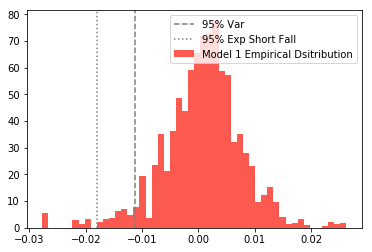

In [17]:
chart = plt.hist(port_ret_m1, 50,
                 density = True, 
                 facecolor = 'xkcd:coral', 
                 label = 'Model 1 Empirical Dsitribution')

chart = plt.axvline(x = rm_emp_model_1['Emp. VAR']['95%'], color = 'grey', 
                    linestyle = '--', 
                    label ='95% Var')

chart = plt.axvline(x = rm_emp_model_1['Emp. Exp. SF']['95%'], color = 'grey', 
                    linestyle = ':', 
                    label ='95% Exp Short Fall')
plt.legend()
plt.show()

In [18]:
#Calculate Risk Measures for Model 1
rm_model_1 = calculate_risk_measures(port_ret_m1, 'Model 1')
rm_model_1

,Exp. SF,VAR
Model 1,,
90%,-0.011518,-0.009807
95%,-0.013680,-0.012359
99%,-0.017911,-0.017145


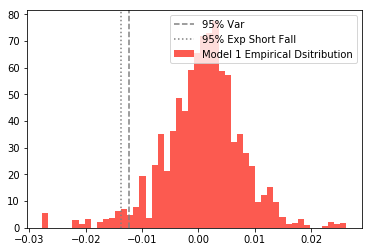

In [39]:
chart = plt.hist(port_ret_m1, 50,
                 density = True, 
                 facecolor = 'xkcd:coral', 
                 label = 'Model 1 Empirical Dsitribution')

chart = plt.axvline(x = rm_model_1['VAR']['95%'], color = 'grey', 
                    linestyle = '--', 
                    label ='95% Var')

chart = plt.axvline(x = rm_model_1['Exp. SF']['95%'], color = 'grey', 
                    linestyle = ':', 
                    label ='95% Exp Short Fall')

plt.legend()
plt.show()

### Question iii)


<b>Model 2</b>

In [20]:
#Model 2
#Create a random return series
random_return_series_m2 = np.random.multivariate_normal(means, 
                                                        cov_mat, 
                                                        size = (10000))

#Calculate Portfolio Return
port_ret_m2 = np.add(np.dot(0.3,[i[0] for i in random_return_series_m2]), 
                     np.dot(0.7,[i[1] for i in random_return_series_m2]))

In [21]:
#Calculate Risk Measures for model 2
rm_model_2 = calculate_risk_measures(port_ret_m2, 'Model 2')
rm_model_2

,Exp. SF,VAR
Model 2,,
90%,-0.009554,-0.007673
95%,-0.011299,-0.009734
99%,-0.014717,-0.013600


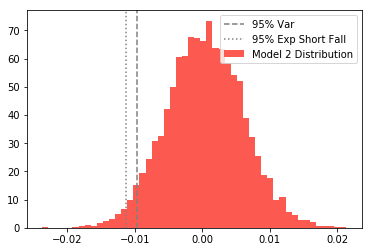

In [22]:
chart = plt.hist(port_ret_m2, 50,
                 density = True, 
                 facecolor = 'xkcd:coral', 
                 label = 'Model 2 Distribution')

chart = plt.axvline(x = rm_model_2['VAR']['95%'], color = 'grey', 
                    linestyle = '--', 
                    label ='95% Var')

chart = plt.axvline(x = rm_model_2['Exp. SF']['95%'], color = 'grey', 
                    linestyle = ':', 
                    label ='95% Exp Short Fall')
plt.legend()
plt.show()

<b>Model 4</b>

In [23]:
random_return_series_m4 = model_4(data_500, 1000)
rm_model_4 = calculate_risk_measures(random_return_series_m4, 'Model 4')
rm_model_4

,Exp. SF,VAR
Model 4,,
90%,-0.012428,-0.010084
95%,-0.014709,-0.012778
99%,-0.019176,-0.017830


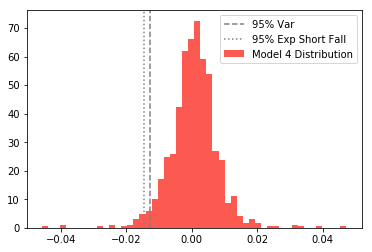

In [24]:
chart = plt.hist(random_return_series_m4, 50,
                 density = True, 
                 facecolor = 'xkcd:coral', 
                 label = 'Model 4 Distribution')

chart = plt.axvline(x = rm_model_4['VAR']['95%'], color = 'grey', 
                    linestyle = '--', 
                    label ='95% Var')

chart = plt.axvline(x = rm_model_4['Exp. SF']['95%'], color = 'grey', 
                    linestyle = ':', 
                    label ='95% Exp Short Fall')
plt.legend()
plt.show()

### Question iv)

In [25]:
def historic_EF(data):
    #Data has to be a pandas series with 1000 historical returns 
    
    #Define dictionary to store the values in
    output_EF = dict.fromkeys(['100','200','500','1000'])

    #Calculate the Expected Short Fall for the latest 100 observations
    output_EF['100'] = [exp_shortfall(0.1,    data.iloc[0:100]), 
                        exp_shortfall(0.05,   data.iloc[0:100]),
                        exp_shortfall(0.01,   data.iloc[0:100])]

    #Calculate the Expected Short Fall for the latest 200 observations
    output_EF['200'] =  [exp_shortfall(0.1,  data.iloc[0:200]), 
                         exp_shortfall(0.05, data.iloc[0:200]),
                         exp_shortfall(0.01, data.iloc[0:200])]
    
    #Calculate the Expected Short Fall for the latest 500 observations
    output_EF['500'] =  [exp_shortfall(0.1,  data.iloc[0:500]), 
                         exp_shortfall(0.05, data.iloc[0:500]),
                         exp_shortfall(0.01, data.iloc[0:500])]
    
    #Calculate the Expected Short Fall for the latest 1000 observations
    output_EF['1000'] =  [exp_shortfall(0.1,  data.iloc[0:1000]), 
                          exp_shortfall(0.05, data.iloc[0:1000]),
                          exp_shortfall(0.01, data.iloc[0:1000])]

    output_table_EF = pd.DataFrame(output_EF, index = ['90%', '95%', '99%'])
    output_table_EF.index.name = 'EF Hist. R'
    
    return output_table_EF       

def historic_VAR(data):
    #Data has to be a pandas series with 1000 historical returns 
    
    #Define dictionary to store the values in
    output_VAR = dict.fromkeys(['100','200','500','1000'])

    #Calculate the VAR for the latest 100 observations
    output_VAR['100'] = [var(0.1,    data.iloc[0:100]), 
                         var(0.05,   data.iloc[0:100]),
                         var(0.01,   data.iloc[0:100])]

    #Calculate the VAR for the latest 200 observations
    output_VAR['200'] =  [var(0.1,  data.iloc[0:200]), 
                          var(0.05, data.iloc[0:200]),
                          var(0.01, data.iloc[0:200])]
    
    #Calculate the VAR for the latest 500 observations
    output_VAR['500'] =  [var(0.1,  data.iloc[0:500]), 
                          var(0.05, data.iloc[0:500]),
                          var(0.01, data.iloc[0:500])]
    
    #Calculate the VAR for the latest 1000 observations
    output_VAR['1000'] =  [var(0.1,  data.iloc[0:1000]), 
                           var(0.05, data.iloc[0:1000]),
                           var(0.01, data.iloc[0:1000])]

    output_VAR = pd.DataFrame(output_VAR, index = ['90%', '95%', '99%'])
    output_VAR.index.name = 'VAR Hist. R'
    
    return output_VAR       

In [26]:
#Historic expected shortfall for the MXEUC with diffrent number of observations
hist_EF = historic_EF(data['LT Returns'])#
hist_EF

,100,200,500,1000
EF Hist. R,,,,
90%,-0.009762,-0.008883,-0.009402,-0.019875
95%,-0.011500,-0.010489,-0.011138,-0.023350
99%,-0.014901,-0.013633,-0.014539,-0.030155


In [27]:
#Historic expected shortfall for the SPX with diffrent number of observations
historic_VAR(data['LT Returns'])

,100,200,500,1000
VAR Hist. R,,,,
90%,-0.007381,-0.006961,-0.007735,-0.014421
95%,-0.009433,-0.008857,-0.009786,-0.018524
99%,-0.013280,-0.012413,-0.013632,-0.026221


### Question v)
<b>Model 2</b>

In [28]:
#Initilaized List to store the values for var and the 1 day ahead portfolio return
rw_var = []
day_ahead_return = []

for i in range(1,len(data.index) - 201):
    #Get the rolling window 
    rw_data = data.iloc[i:i + 200]

    #Save the actual 1 day ahead (of the window) return in the list
    day_ahead_return.append(data['LT Returns'].iloc[i + 200 + 1])

    #Calculate the moments for that window
    rw_means, rw_cov_mat, _ = sample_moments_indices(rw_data)

    #Simulated index returns on the basis of the rolling window monents
    rw_sim_returns = np.random.multivariate_normal(rw_means, rw_cov_mat, size = 100)

    #Calculte the simululated portfolio return
    #'[i[0] for i in rw_sim_returns]' gives the first/second elements 
    #from the 2 dimensional vector 'rw_sim_returns'
    rw_port_returns = np.add(np.dot(0.3,[i[0] for i in rw_sim_returns]), 
                             np.dot(0.7,[i[1] for i in rw_sim_returns]))

    #Calculate Var and store it in the list
    rw_var.append(var(0.05, rw_port_returns))

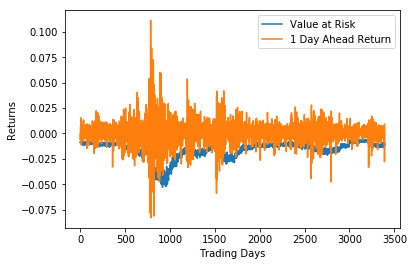

In [29]:
plt.plot(rw_var, label = 'Value at Risk')
plt.plot(day_ahead_return, label = '1 Day Ahead Return')

plt.xlabel('Trading Days')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [30]:
#Count the number of times the the VAR was violated
count = 0
loc = []
for i in range(0,len(rw_var)):
    if rw_var[i] > day_ahead_return[i]:
        count += 1  
        loc.append(i)
        
print('Model 2: The Var was violated ',count,' times which is ',
      round(count/len(rw_var)*100,2),' Percent')

Model 2: The Var was violated  191  times which is  5.63  Percent


<b>Model 4</b>

In [31]:
rw_var = []
day_ahead_return = []

for i in range(1,len(data.index) - 201):
    
    #Get the rolling window 
    rw_data = data.iloc[i:i + 200]

    #Save the actual 1 day ahead (of the window) return in the list
    day_ahead_return.append(data['LT Returns'].iloc[i + 200 + 1])

    #Calculate the moments for that window
    rw_means, rw_cov_mat, rw_stds = sample_moments_indices(rw_data)

    #Simulated index returns on the basis of the rolling window monents
    rw_port_returns = model_4(rw_data, size = 1000)

    #Calculate Var and store it in the list
    rw_var.append(var(0.05, rw_port_returns))

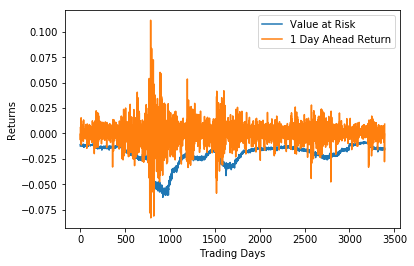

In [32]:
plt.plot(rw_var, label = 'Value at Risk')
plt.plot(day_ahead_return, label = '1 Day Ahead Return')

plt.xlabel('Trading Days')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [33]:
#Count the number of times the the VAR was violated
count = 0
loc = []
for i in range(0,len(rw_var)):
    if rw_var[i] > day_ahead_return[i]:
        count += 1  
        loc.append(i)
        
print('Model 4: The Var was violated ',count,' times which is ',
      round(count/len(rw_var)*100,2),' Percent')

Model 4: The Var was violated  117  times which is  3.45  Percent
